In [1]:
import os
import itertools

import pandas
import matplotlib
import seaborn
import lifelines

from lifelines.statistics import logrank_test

In [2]:
FIG_SIZE = (7, 4)
FIG_SIZE_WIDE = tuple([x * 1.5 for x in FIG_SIZE])
FIGURE_PATH = '../figures'
ECOSYSTEMS = ['Cargo', 'NPM', 'Packagist', 'Rubygems']
DATE_RANGE = pandas.to_datetime('2013-01-01'), pandas.to_datetime('2018-03-14')
CENSOR_DATE = pandas.to_datetime('2018-01-01')
P_VALUE = 0.05  # Not corrected

PALETTE = seaborn.color_palette()
SEC_PALETTE = seaborn.color_palette('hls')[:3:][::-1] + seaborn.color_palette('hls')[3:]
COLORS = {e: PALETTE[i] for i, e in enumerate(ECOSYSTEMS)}

In [3]:
%matplotlib inline

matplotlib.rcParams['figure.figsize'] = FIG_SIZE
matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']

def _savefig(fig, name):
    fig.savefig(
        os.path.join(FIGURE_PATH, '{}.pdf'.format(name)),
        bbox_inches='tight'
    )

# Disable figure export
savefig = lambda x, y: None
#savefig = _savefig

In [4]:
def double_legend(ax, labels_1, colors_1, labels_2, styles_2, *, kw1=None, kw2=None):
    kw1 = dict() if kw1 is None else kw1
    kw2 = dict() if kw2 is None else kw2
    
    lines = [matplotlib.lines.Line2D([0], [0], color=color) for color in colors_1]
    legend_1 = ax.legend(lines, labels_1, **kw1)
    ax.add_artist(legend_1)
    lines = [matplotlib.lines.Line2D([0], [0], color='k', linestyle=s) for s in styles_2]
    legend_2 = ax.legend(lines, labels_2, **kw2)
    return legend_1, legend_2


def grid_for_labels(df, columns, labels=None, colors=SEC_PALETTE):
    if labels is None:
        labels = columns
        
    fig, axes = matplotlib.pyplot.subplots(nrows=int((len(ECOSYSTEMS) / 2 + 0.5) // 1), ncols=2, sharex=True, sharey=True)
    fig.set_size_inches(FIG_SIZE_WIDE)
    
    data = dict()
    for i, ecosystem in enumerate(ECOSYSTEMS):
        ax = [ax for row in axes for ax in row][i]

        df_temp = (
            df[ecosystem]
            .assign(version=1)
            .groupby(pandas.Grouper(key='date', freq='1M'))
            [columns + ['version']]
            .sum()
            .query('version > 0')
            .apply(lambda d: d / d['version'], axis=1)
            [columns]
        )
        data[ecosystem] = df_temp
        df_temp.plot(ax=ax, legend=False, color=colors)

        ax.set(
            title=ecosystem,
            xlabel='',
            ylabel='',
        )

    lines = [matplotlib.lines.Line2D([0], [0], color=color) for color in colors[:len(labels)]]
    axes[-1][0].legend(lines, labels, loc='upper left', ncol=len(labels), bbox_to_anchor=(0, -0.15))

    axes[0][0].set(
        xlim=DATE_RANGE,
        ylim=(0, 1),
    )
    return fig, axes, data


In [5]:
df_versions = dict()
for ecosystem in ECOSYSTEMS:
    print('Loading', ecosystem)
    df_versions[ecosystem] = (
        pandas.read_csv(
            '../data/{}-versions.csv.gz'.format(ecosystem),
        )
        .assign(
            date=lambda d: pandas.to_datetime(d['date'], infer_datetime_format=True),
        )
    )
    
    print('.. identify next release')
    df_versions[ecosystem] = (
        df_versions[ecosystem]
        .merge(
            (
                df_versions[ecosystem]
                .assign(rank=lambda d: d['rank'] - 1)
                .rename(columns={'date': 'next_date'})
                [['package', 'rank', 'next_date']]
            ),
            how='left',
            on=['package', 'rank']
        )
    )
    
print('Done!')

Loading Cargo
.. identify next release
Loading NPM
.. identify next release
Loading Packagist
.. identify next release
Loading Rubygems
.. identify next release
Done!


In [6]:
df_dependencies = dict()
for ecosystem in ECOSYSTEMS:
    print('Loading', ecosystem)
    df_dependencies[ecosystem] = (
        pandas.read_csv(
            '../data/{}-dependencies.csv.gz'.format(ecosystem),
        )
        .merge(
            df_versions[ecosystem][['package', 'version', 'rank', 'date', 'next_date']],
            how='left',
            on=['package', 'version']
        )
    )
print('Done!')

Loading Cargo
Loading NPM
Loading Packagist
Loading Rubygems
Done!


In [7]:
df_constraints = dict()

for ecosystem in ECOSYSTEMS:
    print('Loading', ecosystem)
    
    df_tmp = df_dependencies[ecosystem].sort_values('rank')
    
    df_constraints[ecosystem] = (
        df_tmp
        .drop_duplicates(['package', 'target', 'constraint'], keep='first')
        .merge(
            (
                df_tmp
                .drop_duplicates(['package', 'target', 'constraint'], keep='last')
                [['package', 'target', 'constraint', 'rank', 'next_date']]
                .assign(next_rank=lambda d: (d['rank'] + 1).where(~d['next_date'].isnull()))
                .rename(columns={'next_date': 'constraint_next_date', 'next_rank': 'constraint_next_rank'})
                [['package', 'target', 'constraint', 'constraint_next_date', 'constraint_next_rank']]
            ),
            how='left',
            on=['package', 'target', 'constraint']
        )
        .merge(
            (
                df_tmp
                .drop_duplicates(['package', 'target'], keep='first')
                .assign(constraint_is_new=True)
                [['package', 'target', 'rank', 'constraint_is_new']]
            ),
            how='left',
            on=['package', 'target', 'rank']
        )
        .fillna({'constraint_is_new': False})
    )
print('Done!')

Loading Cargo
Loading NPM
Loading Packagist
Loading Rubygems
Done!


# Overview

## Number of packages and releases

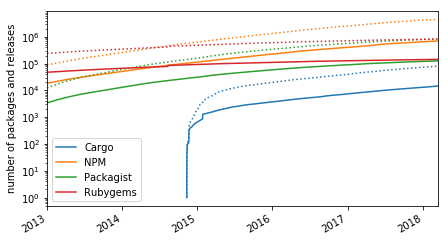

In [8]:
fig, ax = matplotlib.pyplot.subplots()

for ecosystem in ECOSYSTEMS:
    df_tmp = (
        df_versions[ecosystem]
        .set_index('date')
        .sort_index()
    )
    
    (
        df_tmp
        .drop_duplicates(['package'], keep='first')
        .assign(**{ecosystem: 1})
        [[ecosystem]]
        .cumsum()
        .plot(ax=ax, color=COLORS[ecosystem])
    )
    
    (
        df_tmp
        .assign(**{ecosystem: 1})
        [[ecosystem]]
        .cumsum()
        .plot(ax=ax, legend=False, style=':', color=COLORS[ecosystem])
    )
    
ax.set(
    xlabel='',
    xlim=DATE_RANGE,
    ylabel='number of packages and releases',
    yscale='log', 
)

savefig(fig, 'overview_number_packages_releases')

## Number of dependencies

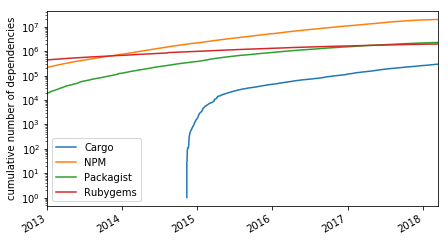

In [9]:
fig, ax = matplotlib.pyplot.subplots()

for ecosystem in ECOSYSTEMS:
    (
        df_dependencies[ecosystem]
        .set_index('date')
        .sort_index()
        .assign(**{ecosystem: 1})
        [[ecosystem]]
        .cumsum()
        .plot(ax=ax, color=COLORS[ecosystem])
    )
    
ax.set(
    xlabel='',
    xlim=DATE_RANGE,
    ylabel='cumulative number of dependencies',
    yscale='log', 
)

savefig(fig, 'overview_number_dependencies')

## Proportion of valid internal dependencies by month

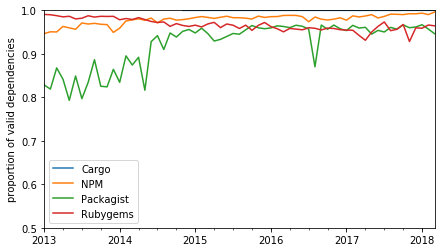

In [10]:
fig, ax = matplotlib.pyplot.subplots()

for ecosystem in ECOSYSTEMS:
    (
        df_dependencies[ecosystem]
        .assign(version=1)        
        .groupby(pandas.Grouper(key='date', freq='1M'))
        [['empty', 'version']]
        .sum()
        .assign(**{ecosystem: lambda d: (d['version'] - d['empty']) / d['version']})
        [[ecosystem]]
        .plot(ax=ax, color=COLORS[ecosystem])
    )
    
ax.set(
    xlabel='',
    xlim=DATE_RANGE,
    ylabel='proportion of valid dependencies',
    ylim=(0.5, 1.00),
)

savefig(fig, 'overview_proportion_valid_dependencies')

# Package updates

## Number of updates by month

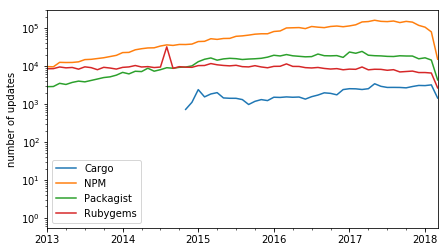

In [11]:
fig, ax = matplotlib.pyplot.subplots()

for ecosystem in ECOSYSTEMS:
    (
        df_versions[ecosystem]
        .groupby(pandas.Grouper(key='date', freq='1M'))
        [['version']]
        .count()
        .rename(columns={'version': ecosystem})
        [[ecosystem]]
        .plot(ax=ax, color=COLORS[ecosystem])
    )
    
ax.set(
    xlabel='',
    xlim=DATE_RANGE,
    ylabel='number of updates',
    yscale='log',
)

savefig(fig, 'update_number_by_month')

## Proportion of 0.x.x releases by month

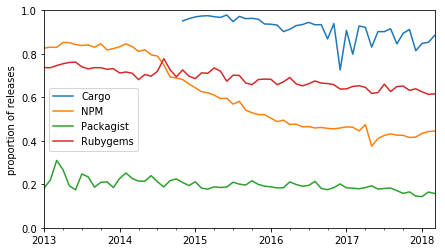

In [12]:
fig, ax = matplotlib.pyplot.subplots()

for ecosystem in ECOSYSTEMS:
    (
        df_versions[ecosystem]
        .assign(zero=lambda d: d['version'].str.startswith('0.'))
        .assign(version=1)
        .groupby(pandas.Grouper(key='date', freq='1M'))
        [['version', 'zero']]
        .sum()
        .assign(**{ecosystem: lambda d: d['zero'] / d['version']})
        [[ecosystem]]
        .plot(ax=ax, color=COLORS[ecosystem])
    )
    
ax.set(
    xlabel='',
    xlim=DATE_RANGE,
    ylabel='proportion of releases',
    ylim=(0, 1),
)

savefig(fig, 'update_proportion_development')

## Proportion of major, minor and patches by month

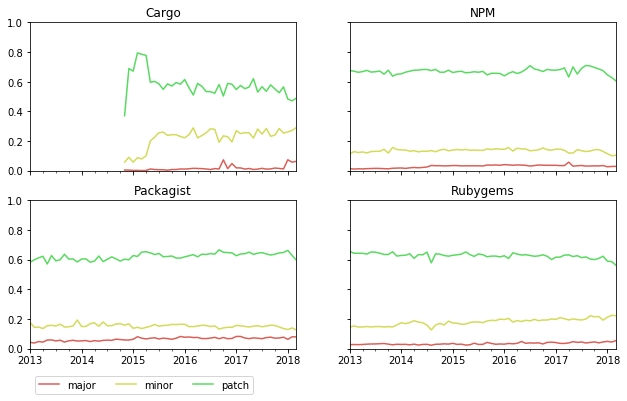

In [13]:
df_temp = {ecosystem: df.assign(
    patch=lambda d: d['type'] == 'patch',
    minor=lambda d: d['type'] == 'minor',
    major=lambda d: d['type'] == 'major',
) for ecosystem, df in df_versions.items()}

fig, axes, data = grid_for_labels(df_temp, ['major', 'minor', 'patch'], colors=SEC_PALETTE[:3][::-1])
savefig(fig, 'update_prop_major_minor_patch_by_month')

## Duration of a release (by type)

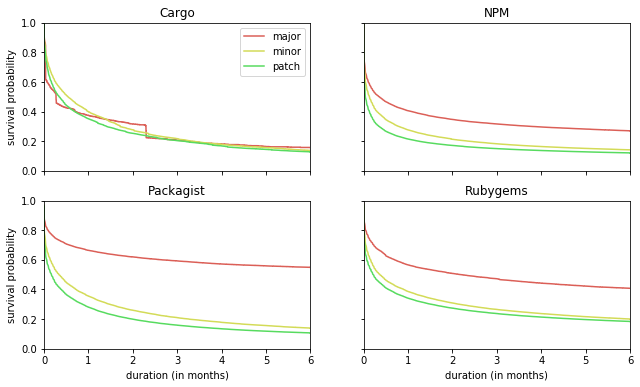

In [14]:
fig, axes = matplotlib.pyplot.subplots(nrows=2, ncols=2, sharex=True, sharey=True)
fig.set_size_inches(FIG_SIZE_WIDE)

for i, ecosystem in enumerate(ECOSYSTEMS):
    ax = [ax for row in axes for ax in row][i]
    df_temp = (
        df_versions[ecosystem]
        .query('type != "initial"')
        .assign(delay=lambda d: (d['next_date'].fillna(CENSOR_DATE) - d['date']) / pandas.to_timedelta(30, unit='days'))
        .assign(observed=lambda d: ~d['next_date'].isnull())
    )

    for j, release_type in enumerate(['major', 'minor', 'patch']):
        kmp = lifelines.KaplanMeierFitter()
        data = df_temp[lambda d: d['type'] == release_type]
        kmp.fit(data['delay'], data['observed'], label=release_type)
        kmp.plot(ax=ax, c=SEC_PALETTE[:3][::-1][j], ci_show=False, legend=False)

    ax.set(
        xlabel='duration (in months)',
        xlim=(0, 6),
        ylabel='survival probability',
        ylim=(0, 1),
        title=ecosystem,
    )

axes[0][0].legend()
    
savefig(fig, 'update_release_duration_survival')

## Evolution of the duration of a release

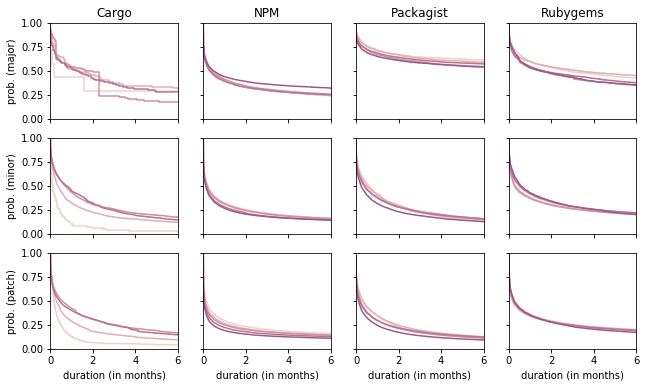

In [15]:
fig, axes = matplotlib.pyplot.subplots(nrows=3, ncols=len(ECOSYSTEMS), sharex=True, sharey=True)
fig.set_size_inches(FIG_SIZE_WIDE)

for i, ecosystem in enumerate(ECOSYSTEMS):
    df_temp = (
        df_versions[ecosystem]
        [lambda d: (d['date'] >= DATE_RANGE[0]) & (d['date'] < DATE_RANGE[1])]
        .query('type != "initial"')
        .assign(delay=lambda d: (d['next_date'].fillna(CENSOR_DATE) - d['date']) / pandas.to_timedelta(30, unit='days'))
        .assign(observed=lambda d: ~d['next_date'].isnull())
    )

    for j, release_type in enumerate(['major', 'minor', 'patch']):
        data = (
            df_temp
            [lambda d: d['type'] == release_type]
            .groupby(pandas.Grouper(key='date', freq='Y'))
        )
        
        kmp = lifelines.KaplanMeierFitter()
        ax = axes[j][i]
        
        for k, (year, group) in enumerate(data):
            if year >= pandas.to_datetime('2018-01-01'):
                continue
            kmp.fit(group['delay'], group['observed'], label=year)
            kmp.plot(ax=ax, c=seaborn.cubehelix_palette(8)[k], ci_show=False, legend=False)

        ax.set(
            xlabel='duration (in months)',
            xlim=(0, 6),
            ylabel='prob. ({})'.format(release_type),
            ylim=(0, 1),
        )
        
        if j == 0:
            ax.set(title=ecosystem)
    
savefig(fig, 'update_release_duration_evolution')

# Dependency constraints

## Proportion strict, upper and lower bounded

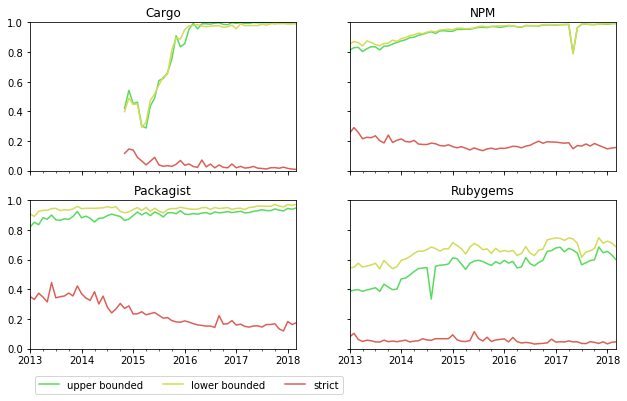

In [16]:
fig, axes, data = grid_for_labels(df_dependencies, ['upper_bounded', 'lower_bounded', 'strict'], ['upper bounded', 'lower bounded', 'strict'])

savefig(fig, 'deps_proportion_strict_bounded')

## Proportion allowing major, minor or patch updates

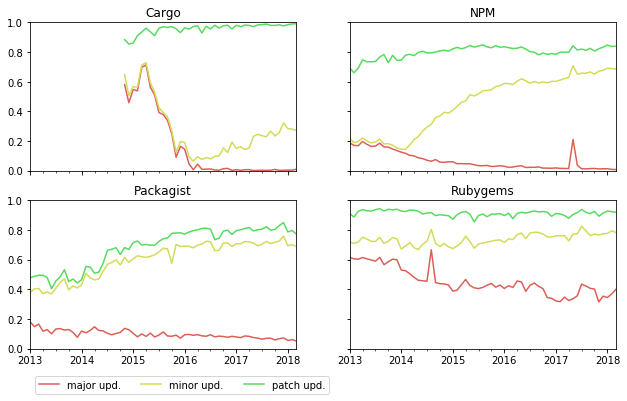

In [17]:
fig, axes, data = grid_for_labels(df_dependencies, ['allows_major', 'allows_minor', 'allows_patch'], ['major upd.', 'minor upd.', 'patch upd.'], SEC_PALETTE[:3][::-1])

savefig(fig, 'deps_proportion_major_minor_patch')

## Proportion allowing backward compatible and backward incompatible updates

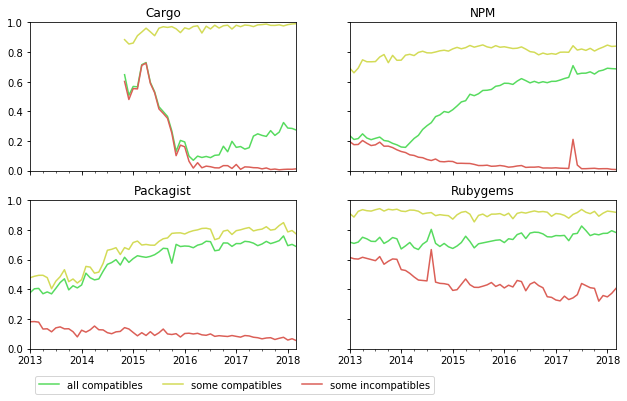

In [18]:
fig, axes, data = grid_for_labels(df_dependencies, ['allows_all_compatible', 'allows_compatible', 'allows_incompatible'], ['all compatibles', 'some compatibles', 'some incompatibles'])

savefig(fig, 'deps_proportion_compatible_incompatible')

## Proportion allowing backward compatible updates only

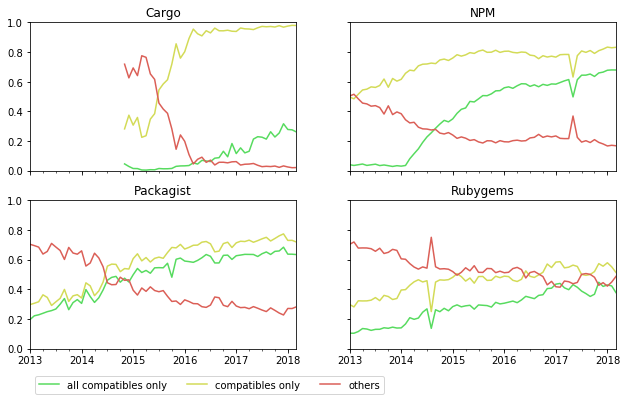

In [36]:
fig, axes, data = grid_for_labels({
        ecosystem: df_dependencies[ecosystem].assign(other=lambda d: ~(d['allows_compatible_only'] | d['allows_all_compatible_only']))
        for ecosystem in ECOSYSTEMS
    }, ['allows_all_compatible_only', 'allows_compatible_only', 'other'], ['all compatibles only', 'compatibles only', 'others'])

savefig(fig, 'deps_proportion_compatible_only')

# Dependency constraints aggregated by releases

## Monthly proportion of releases with at least one strict constraint

## Monthly proportion of releases with bounded constraints

## Monthly proportion of releases with all constraints allowing major, minor or patches updates

## Monthly proportion of releases with all constraints allowing backward compatible/incompatible updates

## Monthly proportion of releases with all constraints allowing backward compatible updates only

# Constraints updates

## Type of releases when a constraint is changed

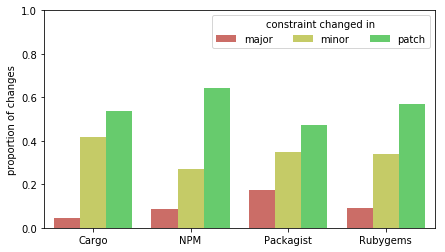

In [20]:
fig, ax = matplotlib.pyplot.subplots()

df_temp = pandas.concat([
    (
        df_constraints[ecosystem]
        [lambda d: ~d['constraint_is_new']]
        .merge(
            df_versions[ecosystem]
            [['package', 'rank', 'type']],
            how='left',
            on=['package', 'rank']
        )
        .groupby('type')
        [['version']]
        .count()
        .apply(lambda s: s / s.sum(), axis=0)
        .reset_index()
        .rename(columns={'version': 'proportion'})
        .assign(ecosystem=ecosystem)
    ) for ecosystem in ECOSYSTEMS
])

seaborn.barplot(
    x='ecosystem',
    y='proportion', 
    hue='type',
    order=ECOSYSTEMS,
    hue_order=['major', 'minor', 'patch'],
    data=df_temp,
    palette=SEC_PALETTE[:3][::-1],
    ax=ax
)

ax.set(
    xlabel='', 
    ylabel='proportion of changes',
    ylim=(0, 1)
)

ax.legend(title='constraint changed in', ncol=3)

savefig(fig, 'constraints_updated_constraints_release_type')

## Proportion of releases by type with a changed constraint

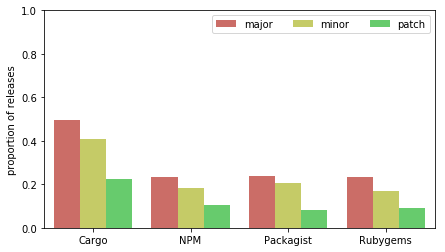

In [21]:
fig, ax = matplotlib.pyplot.subplots()

df_temp = pandas.concat([
    pandas.concat([
        (
            df_constraints[ecosystem]
            [lambda d: ~d['constraint_is_new']]
            .merge(
                df_versions[ecosystem]
                [['package', 'rank', 'type']],
                how='left',
                on=['package', 'rank']
            )
            .drop_duplicates(['package', 'version'])
            .groupby('type')
            [['version']]
            .count()
        ),
        (
            df_versions[ecosystem]
            [lambda d: d['type'] != 'initial']
            [['type']]
            .assign(total=1)
            .groupby(['type'])
            .count()
        )],
        axis=1
    )
    .reset_index()
    .assign(proportion=lambda d: d['version'] / d['total'])
    .assign(ecosystem=ecosystem)
    for ecosystem in ECOSYSTEMS
])

seaborn.barplot(
    x='ecosystem',
    y='proportion', 
    hue='type',
    order=ECOSYSTEMS,
    hue_order=['major', 'minor', 'patch'],
    data=df_temp,
    palette=SEC_PALETTE[:3][::-1],
    ax=ax
)

ax.set(
    xlabel='', 
    ylabel='proportion of releases',
    ylim=(0, 1)
)

ax.legend(ncol=3)

savefig(fig, 'constraints_proportion_of_releases_with_updated_constraints')

## Type of release with a changed constraint, by type of previous constraint

Each constraint category is normalized to 1.0.

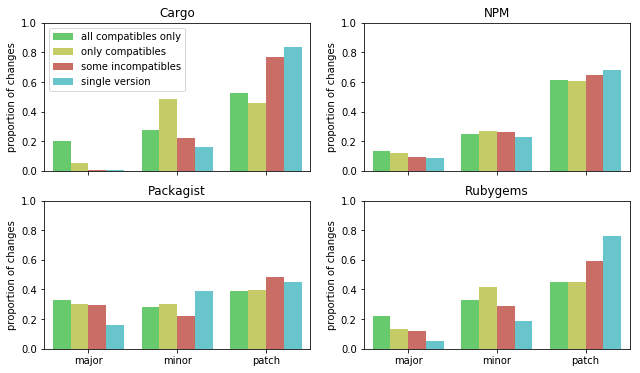

In [22]:
fig, axes = matplotlib.pyplot.subplots(nrows=2, ncols=2, sharex=True, sharey=False)
fig.set_size_inches(FIG_SIZE_WIDE)

for i, ecosystem in enumerate(ECOSYSTEMS):
    ax = [ax for row in axes for ax in row][i]
    
    df_tmp = (
        df_constraints[ecosystem]
        .merge(
            df_versions[ecosystem]
            [['package', 'rank', 'type']],
            how='inner',
            left_on=['package', 'constraint_next_rank'],
            right_on=['package', 'rank']
        )
        .assign(next_type=lambda d: d['type'])
        [['allows_all_compatible_only', 'allows_compatible_only', 'allows_incompatible', 'strict', 'next_type']]
        .pipe(lambda d: 
            pandas.melt(d, id_vars=['next_type'], value_vars=['allows_all_compatible_only', 'allows_compatible_only', 'allows_incompatible', 'strict'], var_name='kind', value_name='changes')
        )
        [lambda d: d['changes']]
        .groupby(['next_type', 'kind'], as_index=False)
        .count()
        .groupby('kind', as_index=False)
        .apply(lambda g: g.assign(proportion=lambda d: d['changes'] / d['changes'].sum()))
        .reset_index(drop=True)
    )
    
    seaborn.barplot(
        data=df_tmp.replace({'kind': {
            'allows_all_compatible_only': 'all compatibles only',
            'allows_compatible_only': 'only compatibles',
            'allows_incompatible': 'some incompatibles', 
            'strict': 'single version',
        }}),
        x='next_type',
        y='proportion',
        hue='kind',
        order=['major', 'minor', 'patch'],
        hue_order=['all compatibles only', 'only compatibles', 'some incompatibles', 'single version'],
        palette=SEC_PALETTE,
        ax=ax
    )
    
    ax.set(
        title=ecosystem,
        xlabel='', 
        ylabel='proportion of changes',
        ylim=(0, 1),
    )

    if i == 0:
        ax.legend(title='', ncol=1, loc='upper left')
    else:
        ax.legend().remove()

savefig(fig, 'constraints_updated_constraints_release_type')

## Delay to update a constraint (in months)

Restrict to packages sufficiently updated. 
We consider the median value as a threshold:

In [23]:
df_frequently_updated = dict()

for ecosystem in ECOSYSTEMS:
    df_temp = (
        df_versions[ecosystem]
        .sort_values('rank')
        .drop_duplicates('package', keep='last')
        [lambda e: e['rank'] > e['rank'].median()]
    )
    print(ecosystem, df_temp['rank'].min())
    df_frequently_updated[ecosystem] = df_temp['package']

Cargo 4
NPM 4
Packagist 4
Rubygems 3


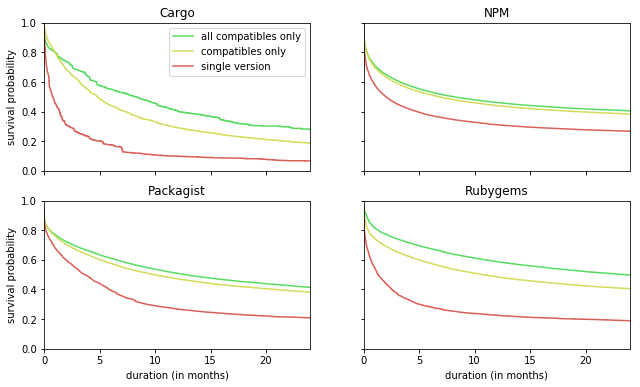

In [24]:
fig, axes = matplotlib.pyplot.subplots(nrows=2, ncols=2, sharex=True, sharey=True)
fig.set_size_inches(FIG_SIZE_WIDE)

categories = [
    ('allows_all_compatible_only', 'all compatibles only'),
    ('allows_compatible_only', 'compatibles only'),
    # ('allows_incompatible', 'some incompatibles'),
    ('strict', 'single version'),
]

test_data = {e: [] for e in ECOSYSTEMS}

for i, ecosystem in enumerate(ECOSYSTEMS):
    ax = [ax for row in axes for ax in row][i]
    df_temp = (
        df_constraints[ecosystem]
        [lambda d: d['package'].isin(df_frequently_updated[ecosystem])]
        .assign(observed=lambda d: ~d['constraint_next_date'].isnull())
        .fillna({'constraint_next_date': CENSOR_DATE})
        .assign(duration=lambda d: (d['constraint_next_date'] - d['date']) / pandas.to_timedelta(30, 'day'))
        # .assign(other=lambda d: ~(d['strict'] | d['allows_compatible_only'] | d['allows_all_compatible_only']))
    )

    for j, (category, label) in enumerate(categories):
        kmp = lifelines.KaplanMeierFitter()
        data = df_temp[lambda d: d[category]]
        
        test_data[ecosystem].append((label, data['duration'], data['observed']))
        kmp.fit(data['duration'], data['observed'], label=label)
        kmp.plot(ax=ax, c=SEC_PALETTE[j], ci_show=False, legend=False)
    
    ax.set(
        xlabel='duration (in months)',
        xlim=(0, 24),
        ylabel='survival probability',
        ylim=(0, 1),
        title=ecosystem,
    )

axes[0][0].legend()
    
savefig(fig, 'constraints_duration_month_per_compatibility')

In [25]:
for ecosystem in ECOSYSTEMS:
    print(ecosystem)
    for group_a, group_b in itertools.combinations(test_data[ecosystem], 2):
        test = logrank_test(
            group_a[1], group_b[1],
            group_a[2], group_b[2],
            alpha=0.95
        )
        print('{} vs {}: {} ({:e})'.format(
            group_a[0], group_b[0], 
            (test.p_value < P_VALUE), test.p_value
        ))
    print()

Cargo
all compatibles only vs compatibles only: True (1.396255e-52)
all compatibles only vs single version: True (0.000000e+00)
compatibles only vs single version: True (0.000000e+00)

NPM
all compatibles only vs compatibles only: True (1.344299e-233)
all compatibles only vs single version: True (0.000000e+00)
compatibles only vs single version: True (0.000000e+00)

Packagist
all compatibles only vs compatibles only: True (1.559438e-77)
all compatibles only vs single version: True (0.000000e+00)
compatibles only vs single version: True (0.000000e+00)

Rubygems
all compatibles only vs compatibles only: True (0.000000e+00)
all compatibles only vs single version: True (0.000000e+00)
compatibles only vs single version: True (0.000000e+00)



## Delay to update a constraint (in number of updates)

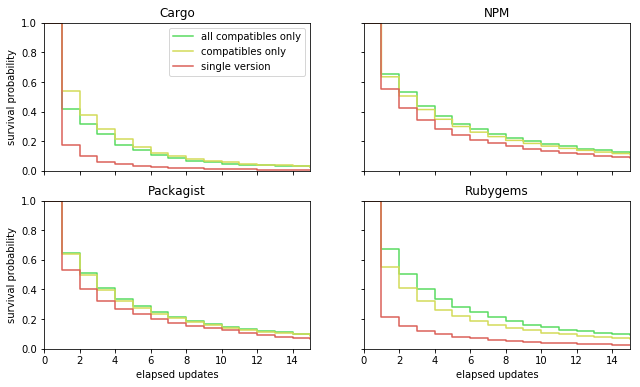

In [26]:
fig, axes = matplotlib.pyplot.subplots(nrows=2, ncols=2, sharex=True, sharey=True)
fig.set_size_inches(FIG_SIZE_WIDE)

categories = [
    ('allows_all_compatible_only', 'all compatibles only'),
    ('allows_compatible_only', 'compatibles only'),
    # ('allows_incompatible', 'some incompatibles'),
    ('strict', 'single version'),
]

test_data = {e: [] for e in ECOSYSTEMS}

for i, ecosystem in enumerate(ECOSYSTEMS):
    ax = [ax for row in axes for ax in row][i]
    df_temp = (
        df_constraints[ecosystem]
        [lambda d: d['package'].isin(df_frequently_updated[ecosystem])]
        [lambda d: ~d['constraint_next_rank'].isnull()]
        .assign(updates=lambda d: (d['constraint_next_rank'] - d['rank']))
        # .assign(other=lambda d: ~(d['strict'] | d['allows_compatible_only'] | d['allows_all_compatible_only']))
    )

    for j, (category, label) in enumerate(categories):
        kmp = lifelines.KaplanMeierFitter()
        data = df_temp[lambda d: d[category]]
        
        test_data[ecosystem].append((label, data['updates']))
        kmp.fit(data['updates'], label=label)
        kmp.plot(ax=ax, c=SEC_PALETTE[j], ci_show=False, legend=False)
    
    ax.set(
        xlabel='elapsed updates',
        xlim=(0, 15),
        ylabel='survival probability',
        ylim=(0, 1),
        title=ecosystem,
    )

axes[0][0].legend()
    
savefig(fig, 'constraints_duration_updates_per_compatibility')

In [27]:
for ecosystem in ECOSYSTEMS:
    print(ecosystem)
    for group_a, group_b in itertools.combinations(test_data[ecosystem], 2):
        test = logrank_test(
            group_a[1], group_b[1],
            alpha=0.95
        )
        print('{} vs {}: {} ({:e})'.format(
            group_a[0], group_b[0], 
            (test.p_value < P_VALUE), test.p_value
        ))
    print()

Cargo
all compatibles only vs compatibles only: True (7.099899e-11)
all compatibles only vs single version: True (1.639491e-111)
compatibles only vs single version: True (2.306273e-306)

NPM
all compatibles only vs compatibles only: True (1.786098e-159)
all compatibles only vs single version: True (0.000000e+00)
compatibles only vs single version: True (0.000000e+00)

Packagist
all compatibles only vs compatibles only: True (1.661968e-09)
all compatibles only vs single version: True (3.499809e-183)
compatibles only vs single version: True (2.672252e-140)

Rubygems
all compatibles only vs compatibles only: True (1.267056e-147)
all compatibles only vs single version: True (0.000000e+00)
compatibles only vs single version: True (0.000000e+00)



## Number of constraint changes w.r.t. constraint type

**TODO**: Try to show that packages using compatible constraints require less constraint changes than other ones

# Required packages

## Number of required packages

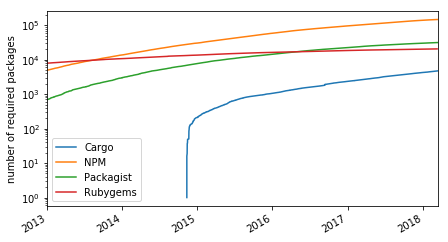

In [28]:
fig, ax = matplotlib.pyplot.subplots()

for ecosystem in ECOSYSTEMS:
    (
        df_dependencies[ecosystem]
        .set_index('date')
        .sort_index()
        .drop_duplicates(['target'], keep='first')
        .assign(**{ecosystem: 1})
        [[ecosystem]]
        .cumsum()
        .plot(ax=ax)
    )
    
ax.set(
    xlabel='',
    xlim=DATE_RANGE,
    ylabel='number of required packages',
    yscale='log',
)

savefig(fig, 'required_number_of_packages')

## Required packages update frequency

## Proportion of required packages by proportion of compatible constraints

In [33]:
date_range = pandas.date_range(*DATE_RANGE, freq='6MS')
labels = ['allows_all_compatible_only', 'allows_compatible_only', 'allows_incompatible', 'strict']
threshold = 0.5

df_temp = dict()

for ecosystem in ECOSYSTEMS:
    print(ecosystem, end=': ')
    df_temp[ecosystem] = pandas.DataFrame(index=date_range[1:], columns=labels)
    
    for i in range(len(date_range) - 1):
        print('.', end='')
        start, stop = i, i + 1

        df_temp[ecosystem].loc[date_range[stop]] = (
            df_dependencies[ecosystem]
            [lambda d: d['date'].between(date_range[start], date_range[stop])]
            # We assume that rows are ordered by date within a single package group
            # This assumption holds for data coming from libraries.io
            #.sort_values('date')
            .drop_duplicates(['package', 'target'], keep='last')
            .assign(dependents=1)
            .groupby('target')
            [['dependents'] + labels]
            .sum()
            # Drop packages with few dependents
            [lambda d: d['dependents'] >= d['dependents'].median()]
            # Identify constraints 
            .apply(lambda d: d >= threshold * d['dependents'], axis=1)
            # Proportion
            .pipe(lambda d: d.sum() / len(d))
            [labels]
        )
    print()

Cargo: ..........
NPM: ..........
Packagist: ..........
Rubygems: ..........


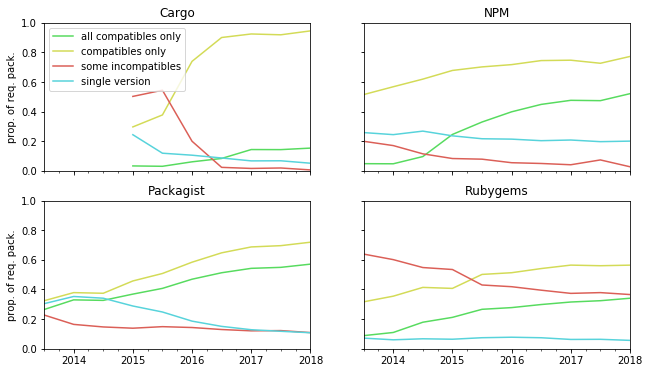

In [34]:
fig, axes = matplotlib.pyplot.subplots(nrows=2, ncols=2, sharex=True, sharey=True)
fig.set_size_inches(FIG_SIZE_WIDE)

categories = [
    ('allows_all_compatible_only', 'all compatibles only'),
    ('allows_compatible_only', 'compatibles only'),
    ('allows_incompatible', 'some incompatibles'),
    ('strict', 'single version'),
]

for i, ecosystem in enumerate(ECOSYSTEMS):
    ax = [ax for row in axes for ax in row][i]
    
    (
        df_temp[ecosystem]
        .rename(columns=dict(categories))
        .plot(ax=ax, color=SEC_PALETTE, legend=False)
    )
    
    ax.set(
        xlabel='',
        xlim=(df_temp[ecosystem].index[0], df_temp[ecosystem].index[-1]),
        ylabel='prop. of req. pack.',
        ylim=(0, 1),
        title=ecosystem,
    )

axes[0][0].legend(loc='upper left')
savefig(fig, 'required_proportion_constraints_per_type')

## Constraint specialization for required packages

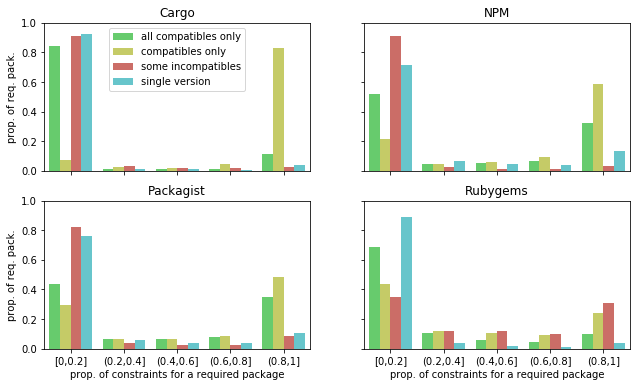

In [32]:
fig, axes = matplotlib.pyplot.subplots(nrows=2, ncols=2, sharex=True, sharey=True)
fig.set_size_inches(FIG_SIZE_WIDE)

categories = [
    ('allows_all_compatible_only', 'all compatibles only'),
    ('allows_compatible_only', 'compatibles only'),
    ('allows_incompatible', 'some incompatibles'),
    ('strict', 'single version'),
]
labels = [a for a, _ in categories]

bins = [0, 0.2, 0.4, 0.6, 0.8, 1]
bins_labels = ['[0,0.2]', '(0.2,0.4]', '(0.4,0.6]', '(0.6,0.8]', '(0.8,1]']

for i, ecosystem in enumerate(ECOSYSTEMS):
    ax = [ax for row in axes for ax in row][i]
    df_temp = (
        df_dependencies[ecosystem]
        .merge(
            df_versions[ecosystem]
            .groupby(['package'], as_index=False, sort=False)
            [['rank']]
            .max(),
            how='left',
            on=['package', 'rank']
        )
        .assign(dependents=1)
        .groupby(['target'], sort=False)
        [['dependents'] + labels]
        .sum()
        # Drop packages with few dependents
        [lambda d: d['dependents'] >= d['dependents'].median()]
    )
    
    df_temp = (
        df_temp
        .pipe(lambda df: 
            pandas.melt(df, id_vars='dependents', value_vars=labels, var_name='kind', value_name='value')
        )
        .assign(value=lambda d: d['value'] / d['dependents'])
        .assign(bins=lambda d: pandas.cut(d['value'], bins=bins, labels=bins_labels, include_lowest=True))
        .groupby(['kind', 'bins'], sort=False)
        [['value']]
        .count()
        / len(df_temp)
    )
    
    seaborn.barplot(
        data=df_temp.reset_index().replace({'kind': dict(categories)}),
        x='bins',
        y='value',
        hue='kind',
        ax=ax,
        palette=SEC_PALETTE,
    )
    ax.legend().remove()
    ax.set(
        title=ecosystem, 
        xlabel='', 
        ylabel='', 
        ylim=(0, 1)
    )

for i in range(0, 2):
    axes[1][i].set(xlabel='prop. of constraints for a required package')
    axes[i][0].set(ylabel='prop. of req. pack.')

axes[0][0].legend(loc='upper center')
savefig(fig, 'required_constraint_specialization')

# Required packages and dependency constraints (2017)

## Correlation between number of release updates & constraint type

## Correlation between release update delay & constraint type

## Correlation between number of release updates & constraint update delay

## Correlation between release update delay & constraint update delay